In [ ]:
!pip install scikit-surprise
!pip install recmetrics

In [2]:
from pathlib import Path

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import surprise
from surprise import accuracy
from surprise.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import recmetrics

data_path = Path("/content/drive/MyDrive/merged_data.csv")

In [3]:
main_df = pd.read_csv(data_path)
main_df = main_df[main_df.state.isin(['PA'])] # Top three states: PA, FL, LA

In [4]:
# create a label encoder for user_id and business_id
(user_encoder, business_encoder) = (LabelEncoder(), LabelEncoder())

# fit the encoders to the data
user_encoder.fit(main_df['user_id'])
business_encoder.fit(main_df['business_id'])

# encode the user_id and business_id columns
main_df['user_id_encoded'] = user_encoder.transform(main_df['user_id'])
main_df['business_id_encoded'] = business_encoder.transform(main_df['business_id'])

main_df.head()

,user_id,business_id,name,state,stars,text,user_id_encoded,business_id_encoded
4,s_9uD6zqVU-9cnKO9pDKtg,jMi5SL9vb6nLJGRjw0HK3Q,Civera's Deli,PA,5,Civera's Deli is the cleanest deli in Delco. E...,35748,16884
6,JOrDiXIgpb0sjtd7Cr3CdA,RUfWgnSSQKjRNBpK0wSxfg,Isabella Pizza,PA,1,Yuck. I ordered here this morning for breakfas...,13018,10173
7,PXywFGVuClrMdFcq5RjsEg,7WWLPXpOjrh_1EvjFuw3hQ,The Drake Tavern,PA,5,Probably the best place to eat in Jenkintown. ...,16808,3076
17,FyIoTnxVTbNar4KdG6cC1w,N1a7z4ID9K0Hqz-Zf3V3yw,US Inspect,PA,5,I recently had a home inspection with Nate Fel...,10781,8582
19,Nro6ABevZFu-8TFDKS-5bw,ctHjyadbDQAtUFfkcAFEHw,Zahav,PA,5,I had the amazing opportunity to eat at Zahab ...,15760,14510


/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/recmetrics/plots.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  head = head.append(tail.head(1))


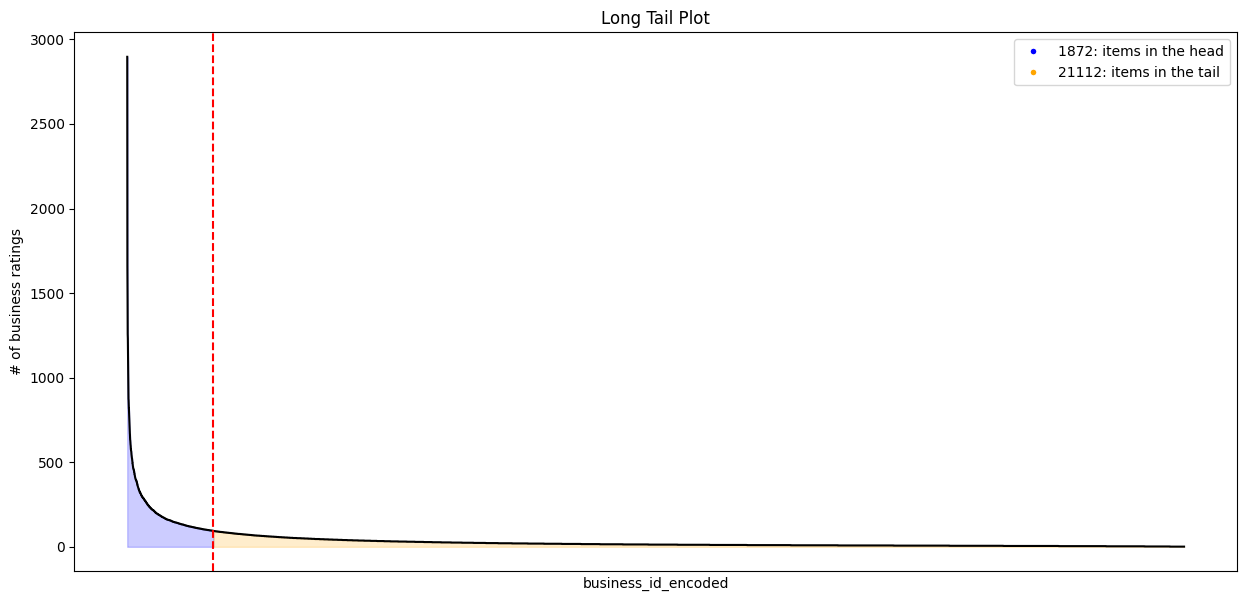

In [5]:
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=main_df, 
             item_id_column="business_id_encoded", 
             interaction_type="business ratings", 
             percentage=0.5,
             x_labels=False)

In [6]:
# Load the DataFrame into a Surprise Dataset object
reader = surprise.Reader(rating_scale=(1, 5))
data = surprise.Dataset.load_from_df(main_df[['user_id_encoded', 'business_id_encoded', 'stars']], reader)

data.df.head()

,user_id_encoded,business_id_encoded,stars
4,35748,16884,5
6,13018,10173,1
7,16808,3076,5
17,10781,8582,5
19,15760,14510,5


In [7]:
(len(data.df["user_id_encoded"].unique()), len(data.df["business_id_encoded"].unique()))

(40502, 22984)

In [8]:
# Split the data into training and testing sets
train, test = train_test_split(data, test_size=0.25)

In [9]:
(train.n_items, train.n_users)

(22847, 39600)

In [10]:
df_test = pd.DataFrame(test, columns=["user_id", "business_id", "stars"])

# Groupby user_id to get all the actual businesses
df_test = df_test.groupby("user_id", as_index=False)["business_id"].agg({'actual': lambda x: list(set(x))})
df_test = df_test.set_index("user_id")
df_test.head()

,actual
user_id,
0,[16691]
1,"[20129, 16099, 3627, 13519, 21489, 9052]"
3,"[15044, 6024, 7208, 14509, 815, 7440, 18461, 2..."
4,"[4571, 11022]"
5,"[15362, 2219, 12464, 9402, 13150]"


# Baseline Models

> [link](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#prediction-algorithms)

- ALS (Alternating Least Squares)
- SGD (Stochastic Gradient Descent)
- SVD (Singular Value Decomposition)
- NMF (Non-Negative Matrix Factorization)

In [30]:
eval_metrics = {
    "model": ["ALS", "SGD", "SVD", "NMF"],
    "MAE": [0.0] * 4,
    "RMSE": [0.0] * 4
    }
base_metrics_df = pd.DataFrame(eval_metrics)

## ALS

In [31]:
als_fitted = surprise.BaselineOnly(bsl_options={"method": "als"}).fit(train)
als_fitted

Estimating biases using als...


In [32]:
preds = als_fitted.test(test)
df_preds = pd.DataFrame(
    preds, columns=['uid', 'iid', 'actual', 'preds', 'details']
    ).drop(columns=['details'])
df_preds.head()

,uid,iid,actual,preds
0,16946,174,5.0,3.153517
1,14603,3517,3.0,4.416581
2,37492,4870,5.0,3.214316
3,27771,5777,4.0,4.025902
4,37917,1567,1.0,2.214685


In [34]:
base_metrics_df.loc[base_metrics_df.model == 'ALS', "MAE"] = accuracy.mae(preds)
base_metrics_df.loc[base_metrics_df.model == 'ALS', "RMSE"] = accuracy.rmse(preds)

MAE:  0.8862
RMSE: 1.1151


## SGD

In [35]:
sgb_fitted = surprise.BaselineOnly(bsl_options={"method": "sgd"}).fit(train)
sgb_fitted

Estimating biases using sgd...


In [36]:
preds = sgb_fitted.test(test)
df_preds = pd.DataFrame(
    preds, columns=['uid', 'iid', 'actual', 'preds', 'details']
    ).drop(columns=['details'])
df_preds.head()

,uid,iid,actual,preds
0,16946,174,5.0,3.033961
1,14603,3517,3.0,4.661545
2,37492,4870,5.0,3.222348
3,27771,5777,4.0,4.271398
4,37917,1567,1.0,1.635888


In [37]:
base_metrics_df.loc[base_metrics_df.model == 'SGD', "MAE"] = accuracy.mae(preds)
base_metrics_df.loc[base_metrics_df.model == 'SGD', "RMSE"] = accuracy.rmse(preds)

MAE:  0.8684
RMSE: 1.1065


## SVD

In [38]:
# Using SVD algorithm
svd_trained = surprise.SVD().fit(train)
svd_trained

In [39]:
preds = svd_trained.test(test)
df_preds = pd.DataFrame(
    preds, columns=['uid', 'iid', 'actual', 'preds', 'details']
    ).drop(columns=['details'])
df_preds.head()

,uid,iid,actual,preds
0,16946,174,5.0,3.201342
1,14603,3517,3.0,4.465199
2,37492,4870,5.0,4.429672
3,27771,5777,4.0,4.091815
4,37917,1567,1.0,1.517464


In [40]:
base_metrics_df.loc[base_metrics_df.model == 'SVD', "MAE"] = accuracy.mae(preds)
base_metrics_df.loc[base_metrics_df.model == 'SVD', "RMSE"] = accuracy.rmse(preds)

MAE:  0.8769
RMSE: 1.1157


## NMF

In [41]:
# NMF
nmf_trained = surprise.NMF(n_factors=50, n_epochs=20, biased=False).fit(train)
nmf_trained

In [42]:
preds = nmf_trained.test(test)
df_preds = pd.DataFrame(
    preds, columns=['uid', 'iid', 'actual', 'preds', 'details']
    ).drop(columns=['details'])
df_preds.head()

,uid,iid,actual,preds
0,16946,174,5.0,5.000000
1,14603,3517,3.0,5.000000
2,37492,4870,5.0,5.000000
3,27771,5777,4.0,5.000000
4,37917,1567,1.0,1.866002


In [43]:
base_metrics_df.loc[base_metrics_df.model == 'NMF', "MAE"] = accuracy.mae(preds)
base_metrics_df.loc[base_metrics_df.model == 'NMF', "RMSE"] = accuracy.rmse(preds)

MAE:  1.0939
RMSE: 1.5713


In [44]:
base_metrics_df

,model,MAE,RMSE
0,ALS,0.886208,1.115147
1,SGD,0.868432,1.106479
2,SVD,0.876887,1.115663
3,NMF,1.093931,1.571288
